In [222]:
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from random import sample

X = pd.read_pickle("X.pkl")
y = pd.read_pickle("y.pkl")


Daten wurden geladen, jetzt bereiten wir unsere Daten für die SVM vor:
    - skalieren
    - in ein np.array umwandeln
    - die Werte der y-Variablen von {0,1} auf {-1,1} skalieren

In [223]:
X = np.array(X)
y_zero_one = y['death_event'].to_numpy()
print(y_zero_one)
y_ones = np.where(y == 0, -1, 1)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


Als nächstes schreiben wir eine Klasse für das Trainning einer SVM mit Gradientenabstieg. Wir verwenden ein Soft Margin SVM mit Hinge Loss:
$$
\mathcal{L}(w, b) = \frac{1}{2} \|w\|^2 + C \cdot \frac{1}{n} \sum_{i=1}^n \max\left(0, 1 - y_i \cdot (x_i^\top w + b)\right)
$$

In [224]:
def gradient_descent(f, f_gradient, f_hessian, x_0, step_size, max_iter, eps=1e-7):
    d = x_0.shape[0]
    thetas = np.zeros((max_iter,d))
    thetas[0] = x_0

    for i in range(1, max_iter):
        grad = np.squeeze(f_gradient(thetas[i-1]))
        step = step_size(i-1) if callable(step_size) else step_size
        theta_next = thetas[i-1] - step * grad
        thetas[i] = theta_next
        if np.sum(grad**2) < eps*eps:
            break
    return thetas[:i+1]

def hinge_loss(t):
    return np.maximum(0, 1 - t)

def hinge_gradient(t):
    return (t < 1).astype(float) * -1

def svm_loss(w, b, C, x, y):
    loss = 0.5*np.sum(w**2, axis=0) + C/x.shape[0] * np.sum(hinge_loss(y*(np.matmul(x, w) + b)), axis=0)
    print(loss)
    return loss

def svm_gradient(w, b, C, x, y):
    n, d = x.shape
    if w.ndim == 1:
        m = 1
    else:
        m = w.shape[1]
        if isinstance(b, np.ndarray):
            b = b.reshape(1, m) 
    w = w.reshape(d, m)
    y = y.reshape(n, 1)
    w_bar = w + C/n * np.einsum('nm,nd->dm', hinge_gradient(y*(np.matmul(x, w) + b)), y*x)
    b_bar = C/n * np.sum(hinge_gradient(y*(np.matmul(x, w) + b))*y, axis=0, keepdims=True)
    return np.concatenate([w_bar, b_bar], axis=0).squeeze()



class SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, bias=True, C=1,step_size=0.01, max_iter=10000):
        super(SVM_GD, self).__init__()
        
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialisiere Startpunkt: w + b zusammen
        w_0 = np.zeros(n_features + 1)

        # Definiere Loss- und Gradientenfunktionen für Optimierung
        f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X, y)

        # Starte Gradientenabstieg
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)

        # Gewichte und Bias extrahieren aus letztem Punkt der Optimierung
        self.w = trace[-1, :-1]
        self.b = trace[-1, -1] if self.bias else 0
        #print(svm_loss(self.w, self.b, self.C,X,y))
        
        return trace
        
    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.matmul(X, self.w) + self.b
    
class SVM_SGD(SVM_GD):
    def __init__(self, bias=True, batch_size=32, C=1, step_size=0.01, max_iter=10000):
        super(SVM_SGD, self).__init__(bias, C, step_size, max_iter)
        
        self.batch_size = batch_size
    
    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialisiere Startpunkt: w + b zusammen
        w_0 = np.zeros(n_features + 1)

        # Definiere Loss- und Gradientenfunktionen für Optimierung
        f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        
        indices = sample(range(0, X.shape[0]), self.batch_size)
        f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X[indices], y[indices])
        # Starte Gradientenabstieg
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)

        # Gewichte und Bias extrahieren aus letztem Punkt der Optimierung
        self.w = trace[-1, :-1] # wähle letzten Gewichte in SGD, , das sind w1 und w2, die letzte Spalte b, wird nicht mitgenommen
        self.b = trace[-1, -1] if self.bias else 0 # Elment ganz unten rechts

        return trace
    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.matmul(X, self.w) + self.b

from sklearn.metrics import roc_auc_score
svm_gd = SVM_GD(bias=True, step_size=0.1)
svm_sgd = SVM_SGD(bias=True, batch_size=50, step_size=lambda t: 1/(t+1))


svm_sgd.fit(X, y_ones)
pred = svm_sgd.predict(X)
roc = roc_auc_score(pred, y_ones)
print(roc)

Wir schauen jetzt verschiedene Regularisierungen an. Dafür verändern wir die Konstante C in der Lossfunktion:
    - Je größer C gewählt wird, desto kleiner die Regularisierung

In [226]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

accuracy_scores = []
accuracy_scores_scikit = [] 
norms = []
norms_scikit = []
Css = np.arange(0.01, 1, 0.1)
for Cs in Css:
    SVM_model = SVM_GD(C = Cs)
    SVM_model.fit(X,y_ones)
    norms.append(np.linalg.norm(SVM_model.w))
    y_pred = SVM_model.predict(X)
    acc = accuracy_score(y_ones, y_pred)
    accuracy_scores.append(acc)
    #print(f"Training Accuracy: {acc:.2f}")
    
    svm_model = SVC(kernel='linear', C=Cs)
    svm_model.fit(X, y_zero_one)
    y_pred = svm_model.predict(X)
    acc = accuracy_score(y_zero_one, y_pred)
    w = svm_model.coef_[0] 
    norms_scikit.append(np.linalg.norm(w))
    accuracy_scores_scikit.append(acc)
plt.plot(norms, accuracy_scores)
plt.plot(norms_scikit, accuracy_scores_scikit)
plt.xlabel("Norm of weight vector ‖w‖")
plt.ylabel("Accuracy")
plt.legend(["Eigene SVM", "sklearn SVC"])
plt.title("Accuracy vs. Norm of w")
plt.grid(True)
plt.show()


ValueError: Classification metrics can't handle a mix of binary and continuous targets

Bestes C: 6.614740641230145e-05


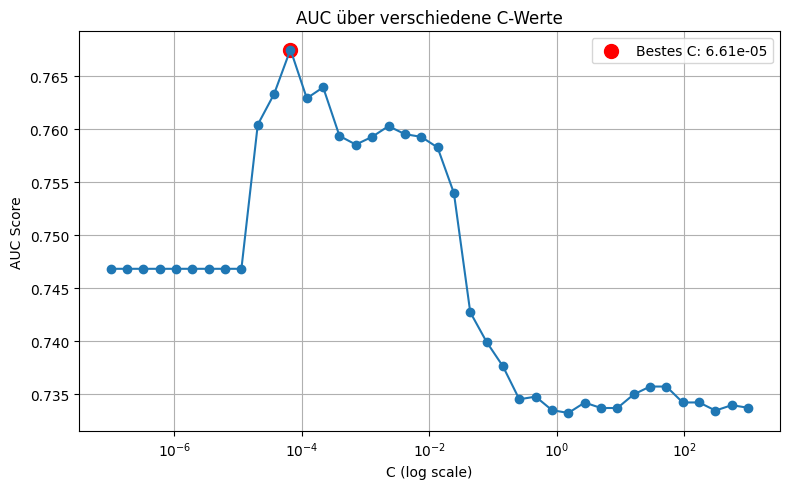

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from random import sample

C_values = np.logspace(-7, 3, 40)
scores = []

for C in C_values:
    clf = SVC(C=C, kernel="linear")
    score = cross_val_score(clf, X, y_zero_one, cv=5, scoring="roc_auc").mean()
    scores.append(score)

best_C = C_values[np.argmax(scores)]
print("Bestes C:", best_C)

best_idx = np.argmax(scores)

plt.figure(figsize=(8, 5))
plt.plot(C_values, scores, marker='o', linestyle='-')
plt.scatter(C_values[best_idx], scores[best_idx], color='red', s=100, label=f'Bestes C: {best_C:.2e}')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('AUC Score')
plt.title('AUC über verschiedene C-Werte')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np
import time

# Daten (X, y_zero_one) sind gegeben

# Daten: X, y_zero_one
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

C_values = np.logspace(-4, 3, 40)
param_grid = {'C': C_values}

outer_scores = []
run_times = []

for train_idx, test_idx in outer_cv.split(X, y_zero_one):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_zero_one[train_idx], y_zero_one[test_idx]

    start_time = time.time()
    
    grid = GridSearchCV(SVC(kernel='linear'), param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=1)
    grid.fit(X_train, y_train)

    elapsed = time.time() - start_time
    run_times.append(elapsed)
    
    # Bestes Modell bewerten
    best_model = grid.best_estimator_
    y_score = best_model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    outer_scores.append(auc)

    print(f"Outer Fold AUC: {auc:.4f} | Bestes C: {grid.best_params_['C']:.2e}")

# Gesamtergebnis
print(f"\nNested CV mittlere AUC: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")

plt.subplot(1, 2, 1)
plt.boxplot(outer_scores, vert=True)
plt.ylabel("AUC Score")
plt.title("AUC for outer folds")

# 2. Boxplot für Zeit
plt.subplot(1, 2, 2)
plt.boxplot(run_times, vert=True)
plt.ylabel("running time (sec)")
plt.title("running time for one outer fold")

plt.tight_layout()
plt.show()

Outer Fold AUC: 0.6950 | Bestes C: 1.80e-03
Outer Fold AUC: 0.6850 | Bestes C: 1.51e-04


KeyboardInterrupt: 

Outer Fold AUC: 0.7050 | Bestes C: 1.80e-03
Outer Fold AUC: 0.6800 | Bestes C: 1.19e-03
Outer Fold AUC: 0.6300 | Bestes C: 3.46e-04
Outer Fold AUC: 0.8450 | Bestes C: 4.12e-03
Outer Fold AUC: 0.8200 | Bestes C: 8.89e-01
Outer Fold AUC: 0.7050 | Bestes C: 3.89e-01
Outer Fold AUC: 0.9365 | Bestes C: 1.19e-03
Outer Fold AUC: 0.8995 | Bestes C: 1.19e-03
Outer Fold AUC: 0.7407 | Bestes C: 1.19e-03
Outer Fold AUC: 0.8611 | Bestes C: 1.00e-04

Nested CV mittlere AUC: 0.7823 ± 0.0982


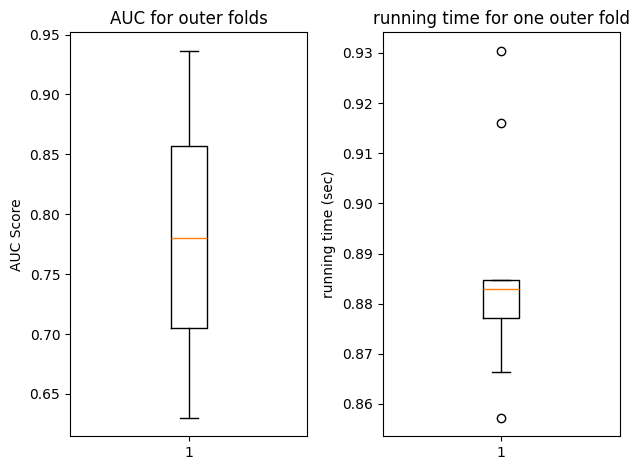

In [ ]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

C_values = np.logspace(-4, 3, 40)
param_grid = {'C': C_values}

outer_scores = []
run_times = []

for train_idx, test_idx in outer_cv.split(X, y_zero_one):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_zero_one[train_idx], y_zero_one[test_idx]

    start_time = time.time()
    
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=1)
    grid.fit(X_train, y_train)

    elapsed = time.time() - start_time
    run_times.append(elapsed)
    
    # Bestes Modell bewerten
    best_model = grid.best_estimator_
    y_score = best_model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    outer_scores.append(auc)

    print(f"Outer Fold AUC: {auc:.4f} | Bestes C: {grid.best_params_['C']:.2e}")

# Gesamtergebnis
print(f"\nNested CV mittlere AUC: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")

plt.subplot(1, 2, 1)
plt.boxplot(outer_scores, vert=True)
plt.ylabel("AUC Score")
plt.title("AUC for outer folds")

# 2. Boxplot für Zeit
plt.subplot(1, 2, 2)
plt.boxplot(run_times, vert=True)
plt.ylabel("running time (sec)")
plt.title("running time for one outer fold")

plt.tight_layout()
plt.show()


Starte Evaluierung: linear kernel GD
linear kernel GD Nested CV mittlere AUC: 0.7844 ± 0.0742
linear kernel GD mittlere Laufzeit: 0.55 Sekunden

Starte Evaluierung: linear kernel SGD
linear kernel SGD Nested CV mittlere AUC: 0.7418 ± 0.0880
linear kernel SGD mittlere Laufzeit: 0.57 Sekunden

Starte Evaluierung: linear kernel
linear kernel Nested CV mittlere AUC: 0.7857 ± 0.0765
linear kernel mittlere Laufzeit: 4.48 Sekunden

Starte Evaluierung: rbf kernel
rbf kernel Nested CV mittlere AUC: 0.7811 ± 0.0894
rbf kernel mittlere Laufzeit: 0.26 Sekunden

Starte Evaluierung: poly kernel
poly kernel Nested CV mittlere AUC: 0.7808 ± 0.1112
poly kernel mittlere Laufzeit: 0.21 Sekunden


C:\Users\User\AppData\Local\Temp\ipykernel_26448\777232263.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(outer_scores_all, labels=model_names, vert=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26448\777232263.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(run_times_all, labels=model_names, vert=True)


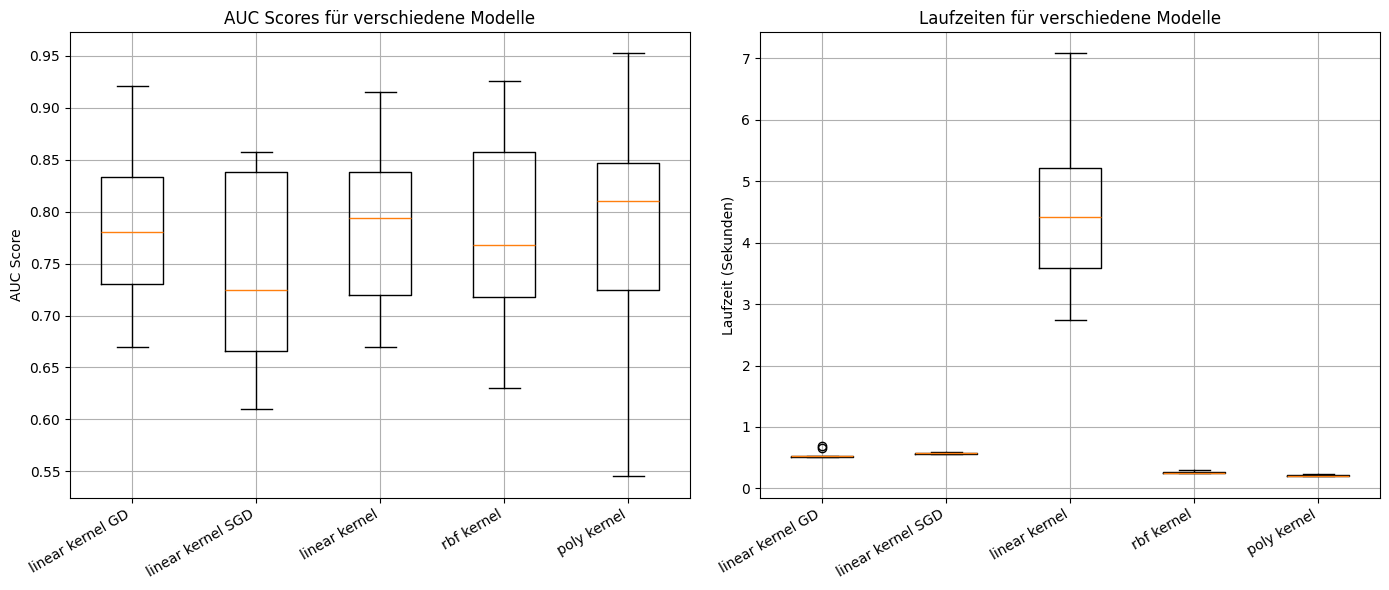

'\n        try:\n            y_score = best_model.decision_function(X_test)\n            auc = roc_auc_score(y_test, y_score)\n        except AttributeError:\n            try:\n                y_score = best_model.predict_proba(X_test)[:, 1]\n                auc = roc_auc_score(y_test, y_score)\n            except AttributeError:\n                from sklearn.metrics import accuracy_score\n                y_pred = best_model.predict(X_test)\n                auc = accuracy_score(y_test, y_pred)\n\n        outer_scores.append(auc)\n'

In [228]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import matplotlib.pyplot as plt

C_values = np.logspace(-4, 3, 10)
param_grid = {'C': C_values}  # Für SVC
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

models = [
    ("linear kernel GD", SVM_GD(bias=True, step_size=0.1)),  # fixe alpha
    ("linear kernel SGD", SVM_SGD(bias=True, batch_size=60, step_size=lambda t: 1/(t+1))),
    ("linear kernel", SVC(kernel='linear')),
    ("rbf kernel", SVC(kernel='rbf')),
    ("poly kernel", SVC(kernel='poly'))
]

outer_scores_all = []
run_times_all = []
model_names = []
for name, model in models:
    print(f"\nStarte Evaluierung: {name}")
    outer_scores = []
    run_times = []
    for train_idx, test_idx in outer_cv.split(X, y_zero_one):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_zero_one[train_idx], y_zero_one[test_idx]
        y_train_ones, y_test_ones = y_ones[train_idx], y_ones[test_idx]

        start_time = time.time()

        if isinstance(model, SVC):
            # GridSearch für SVC mit param_grid {'C': C_values}
            grid = GridSearchCV(model, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            elapsed = time.time() - start_time
            run_times.append(elapsed)
            y_score = best_model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_score)
            outer_scores.append(auc)
            
        else:
            model.fit(X_train, y_train_ones)
            best_model = model
            elapsed = time.time() - start_time
            run_times.append(elapsed)
            
            y_score = best_model.predict(X_test)
            y_score = (y_score + 1) / 2
            auc = roc_auc_score(y_test, y_score)
   
            outer_scores.append(auc)
    outer_scores_all.append(outer_scores)
    run_times_all.append(run_times)
    model_names.append(name)

    print(f"{name} Nested CV mittlere AUC: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    print(f"{name} mittlere Laufzeit: {np.mean(run_times):.2f} Sekunden")

# Visualisierung
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.boxplot(outer_scores_all, labels=model_names, vert=True)
plt.ylabel("AUC Score")
plt.title("AUC Scores für verschiedene Modelle")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(run_times_all, labels=model_names, vert=True)
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Laufzeiten für verschiedene Modelle")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()
"""
        try:
            y_score = best_model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_score)
        except AttributeError:
            try:
                y_score = best_model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_score)
            except AttributeError:
                from sklearn.metrics import accuracy_score
                y_pred = best_model.predict(X_test)
                auc = accuracy_score(y_test, y_pred)

        outer_scores.append(auc)
"""
#TODO schreibe decision function die numerischen wert gibt und pred function die konkret 0,1 angibt